In [1]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [20]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [21]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [22]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [23]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [24]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Оцените модель на разных порогах.
- Проверьте точность простых базовых моделей (dummy baselines).

Dummy baseline — это простая модель, которая предсказывает одну категорию по заранее установленному правилу или случайно. В этом случае базовая точность модели (dummy baseline) равна доле положительных примеров в целевом наборе данных (y_val == churn_decision). Эта метрика задаёт базовый уровень, с которым можно сравнивать производительность модели.

Вычисляется базовая точность, которая просто показывает долю совпадений y_val и churn_decision. Она служит ориентиром, с которым можно сравнивать результаты модели, чтобы понять, насколько модель превосходит или уступает базовым ожиданиям.

In [25]:
len(y_val)

1409

In [26]:
(y_val == churn_decision).mean()

0.8034066713981547

In [27]:
1132/ 1409

0.8034066713981547

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [30]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [31]:
y_pred

array([0.00899456, 0.20447551, 0.21218361, ..., 0.13636236, 0.79975428,
       0.83739606])

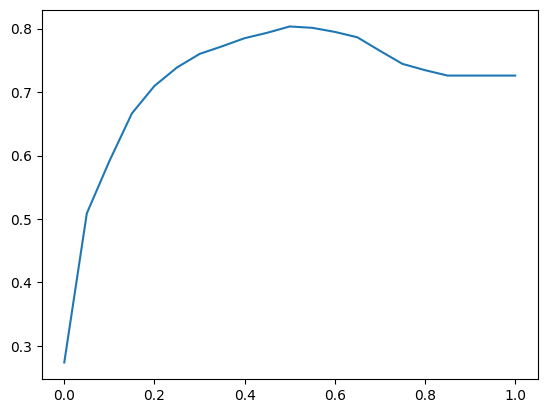

In [14]:
plt.plot(thresholds, scores)

In [34]:
from collections import Counter

In [35]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [39]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

матрица ошибок (confusion matrix) помогает оценить производительность модели, показывая разные типы классификационных решений: верные и ошибочные предсказания.

Когда модель логистической регрессии (LR) делает предсказание, каждое из них попадает в одну из четырех категорий:

Предсказание, что клиент WILL churn. Это называется Positive class
- И клиент действительно ушел — это называется True Positive (TP)
- Но клиент на самом деле не ушел — это называется False Positive (FP)


Предсказание, что клиент WILL NOT churn — это называется Negative class
- Клиент действительно не ушел — True Negative (TN)
- Клиент ушел — False Negative (FN)

Confusion Table позволяет представить результаты выше в табличном формате, как показано ниже:

<table>
  <tr>
    <th></th>
    <th></th>
    <th colspan="2" style="text-align: center;">Predictions</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="text-align: center;">TN</td>
    <td style="text-align: center;">FP</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="text-align: center;">FN</td>
    <td style="text-align: center;">TP</td>
  </tr>
</table>


In [25]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [26]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [27]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [28]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [29]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

**Precision** показывает долю положительных предсказаний, которые являются верными. Этот показатель учитывает только **Positive class** (TP и FP — второй столбец матрицы ошибок), как показано в следующей формуле:

$$
P = \frac{TP}{TP + FP}
$$

**Recall** измеряет долю правильно определенных положительных экземпляров. Он учитывает части как **Positive class**, так и **Negative class** (TP и FN — вторая строка таблицы ошибок). Формула этой метрики представлена ниже:

$$
R = \frac{TP}{TP + FN}
$$

В данной задаче значения precision и recall составили 67% и 54% соответственно. Таким образом, эти показатели отражают некоторые ошибки модели, которые accuracy не заметила из-за **дисбаланса классов**.


**Мнемоника**:

- **Precision**: Из `pre`дсказанных положительных примеров, сколько мы предсказали правильно. Видите, как слово `pre`cision похоже на слово `pre`diction?
  
- **Recall**: Из `real` положительных примеров, сколько мы предсказали правильно. Видите, как слово `re`c`al`l похоже на слово `real`?


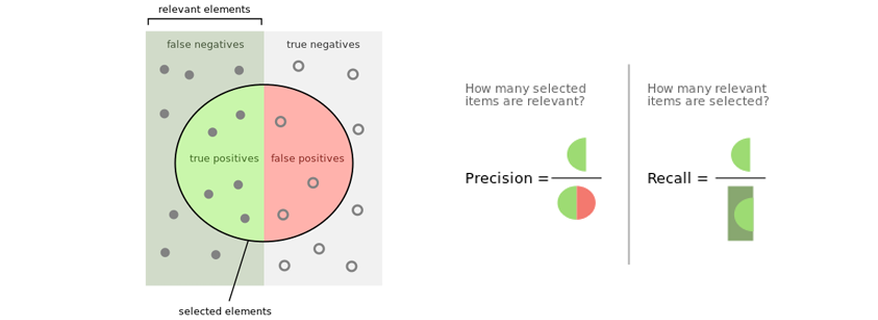

In [30]:
p = tp / (tp + fp)
p

0.6752411575562701

In [31]:
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves

### TPR and FRP

### ROC-кривая (Receiver Operating Characteristic)

**ROC-кривая** — это графическое представление работы классификационной модели на разных порогах вероятности. Она показывает соотношение между **True Positive Rate (TPR)** и **False Positive Rate (FPR)** при изменении порога классификации.

- **True Positive Rate (TPR)**, также известный как **Recall**:
  
  $$
  TPR = \frac{TP}{TP + FN}
  $$

- **False Positive Rate (FPR)**:
  
  $$
  FPR = \frac{FP}{FP + TN}
  $$

#### Интерпретация ROC-кривой

- Точка в левом верхнем углу графика (TPR = 1, FPR = 0) представляет собой идеальный классификатор, который правильно классифицирует все положительные и отрицательные примеры.
- Чем ближе ROC-кривая подходит к левому верхнему углу, тем лучше работает модель.
- Линия, идущая по диагонали от нижнего левого угла к верхнему правому, представляет собой случайный классификатор, где TPR примерно равен FPR. Модель, чья ROC-кривая совпадает с этой диагональю, не имеет способности различать классы.

#### Площадь под ROC-кривой (AUC — Area Under the Curve)

**AUC (Area Under the Curve)** — это площадь под ROC-кривой. Она представляет собой обобщенную метрику качества модели:

- AUC = 1.0: Идеальный классификатор.
- AUC = 0.5: Случайный классификатор, который не различает классы.
- Чем больше значение AUC, тем лучше модель справляется с классификацией положительных и отрицательных примеров.

AUC-ROC позволяет сравнить разные модели и выбрать ту, которая лучше разделяет классы, особенно при наличии дисбаланса классов.

#### Преимущества ROC-кривой

- Позволяет визуально оценить способность модели различать классы на разных порогах.
- Не зависит от распределения классов (устойчив к дисбалансу классов).
- AUC-ROC предоставляет обобщенную метрику, которая упрощает сравнение различных моделей.

#### Недостатки ROC-кривой

- ROC-кривая может быть менее полезна для сильно несбалансированных классов, так как даже высокая FPR может показывать малое абсолютное количество FP из-за доминирования одного класса. В таких случаях стоит обратить внимание на **Precision-Recall Curve**.



In [32]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [33]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [34]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [35]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

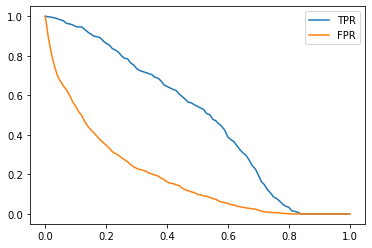

In [36]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [33]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [34]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [35]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [36]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

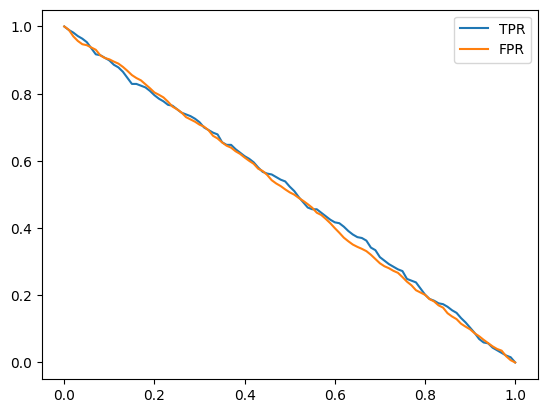

In [37]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [38]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [39]:

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [40]:
np.linspace(0, 1, len(y_val))

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [41]:
1 - y_val.mean()

0.7260468417317246

In [42]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [43]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


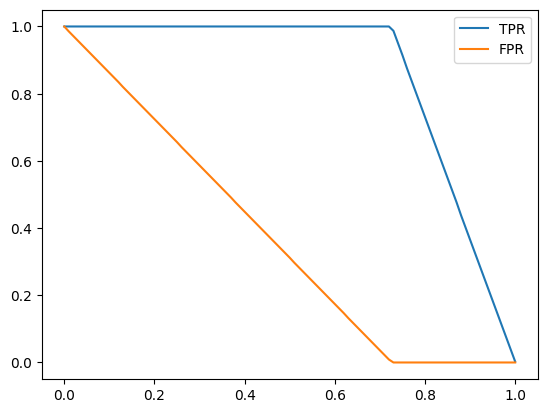

In [44]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

In [45]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

NameError: name 'df_scores' is not defined

In [32]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

NameError: name 'df_scores' is not defined

<Figure size 500x500 with 0 Axes>

In [55]:
from sklearn.metrics import roc_curve

In [57]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

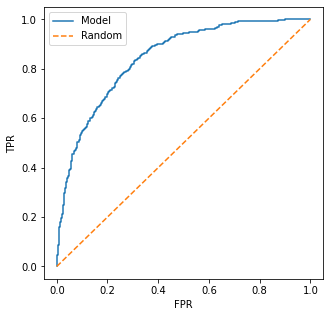

In [58]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [60]:
from sklearn.metrics import auc

In [61]:
auc(fpr, tpr)

0.843850505725819

In [62]:
auc(df_scores.fpr, df_scores.tpr)

0.8438796286447967

In [63]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [68]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.843850505725819

In [65]:
from sklearn.metrics import roc_auc_score

In [66]:
roc_auc_score(y_val, y_pred)

0.843850505725819

In [70]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [73]:
import random

In [82]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8434

In [90]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [121]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [123]:
dv, model = train(df_train, y_train, C=0.001)

In [110]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [98]:
y_pred = predict(df_val, dv, model)

In [99]:
from sklearn.model_selection import KFold

In [112]:
!pip install tqdm

You should consider upgrading via the '/home/alexey/.pyenv/versions/3.8.11/bin/python3.8 -m pip install --upgrade pip' command.


In [113]:
from tqdm.auto import tqdm

In [129]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [133]:
scores

[0.8419433083969826,
 0.8458047775129122,
 0.8325145494681918,
 0.8325466042079682,
 0.8525462018763139]

In [131]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week